# PredIctal: An Automated Seizure Prediction Algorithm

In [14]:
import numpy as np
from scipy.io import loadmat as loadmat
import os
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.signal import (periodogram as periodogram,
                         butter as butter,
                         lfilter as lfilter)
from timeit import default_timer as timer
from sklearn.decomposition import PCA as PCA
from sklearn.svm import SVC as SVC
from sklearn.model_selection import train_test_split as train_test_split
from sklearn.metrics import precision_recall_fscore_support as prf
from copy import copy as copy
from tqdm.notebook import tqdm
import mne
from scipy.signal import decimate
from scipy.interpolate import CubicSpline as CubicSpline

## PreProcessing

In [155]:
class Segment():
    """
    Class for pre-processing individual 10-minute EEG segments and extracting time-frequency representations
    """
    def __init__(self, path, varname, band_centers, filt_ord=1, low_cut=0.5, high_cut=50, down_freq=250, t_split=4):
        self.load_struct(path, varname, down_freq)
        self.filter_seg(filt_ord, low_cut, high_cut, self.fs)
        self.get_tfr(self.filt_data, band_centers)
        self.get_feats(down_freq)
        self.split_seg(t_split)
        
    def load_struct(self, path, var, down_freq):
        """
        Load data from 10-min segment specified by the path and variable name.
        Interpolate up to multiple of downsampling frequency if necessary.
        """
        basepath = os.path.dirname(os.path.realpath("__file__"))
        seg_path = os.path.join(basepath, path)
        seg_struct = loadmat(seg_path)[var][0][0]
        self.raw_data = np.transpose(seg_struct[0])
        self._raw_data = self.raw_data #raw data without interpolation
        self.data_length_sec = seg_struct[1][0][0]
        self.raw_t = np.linspace(0, self.data_length_sec, self.raw_data.shape[0]) #t without interpolation
        self.raw_fs = seg_struct[2][0][0] #sampling freq before interpolation
        self.fs = self.raw_fs
        if self.fs % down_freq != 0: #not an integer mutiple of downsampled frequency
            t = self.raw_t
            cubic_spline = CubicSpline(t, self.raw_data)
            up_freq = down_freq #interpolation sampling frequency
            assert_msg = "Sampling Frequency ({:.2f}) smaller than downsampled frequency ({:.2f})".format(
                self.fs, down_freq)
            assert self.fs > down_freq, assert_msg
            while self.fs > up_freq:
                up_freq += down_freq
                t = np.linspace(0, self.data_length_sec, int(self.data_length_sec*up_freq))
                self.raw_data = cubic_spline(t)
            self.fs = up_freq
        self.channels = []
        for channel in seg_struct[3][0]:
            self.channels.append(channel[0])
        self.num_channels = len(self.channels)
        self.sequence = seg_struct[4][0][0]
        self.t = np.linspace(0, self.data_length_sec, self.raw_data.shape[0])
    
    def filter_seg(self, filt_ord, cutoff_low, cutoff_high, fs):
        """
        Filter raw voltage data using butterworth bandpass filter
        """
        b, a = butter(filt_ord, [cutoff_low, cutoff_high], btype="bandpass", fs=fs)
        self.filt_data = lfilter(b, a, self.raw_data)
    
    def get_tfr(self, data, band_centers):
        """
        Obtain time-frequency representation (tfr) using Morlet Wavelet Convolution
        """
        self.band_centers = band_centers
        data = np.swapaxes(np.expand_dims(data, axis=0), 1, 2)
        tfr = mne.time_frequency.tfr_array_morlet(data, freqs=band_centers, sfreq=int(self.fs), n_cycles=2,
                                                  output='complex')
        self.tfr = tfr[0]
        self.phase = np.angle(self.tfr)
        self.amp = np.abs(self.tfr)
        
    def minmax_norm(self, x):
        """
        Apply min-max normalization.  Returns both normalized x and normalization factor minmax
        """
        max_x = np.max(np.abs(x))
        minmax = np.array([max_x])
        norm_x = x / max_x
        return norm_x, minmax
    
    def z_norm(self, x):
        """
        Apply z-score normalization
        """
        z = (x - np.mean(x)) / np.std(x)
        return z

    def get_feats(self, down_freq):
        """
        Normalize time-frequency representation, decimate, and concatenate together for one feature vector.
        """
        #norm_phase, max_phase = self.minmax_norm(self.phase)
        #norm_amp, max_amp = self.minmax_norm(self.amp)
        norm_phase = self.phase
        norm_amp = self.amp
        n_down = adjusted_ndown = self.fs // down_freq
        while adjusted_ndown > 10: #scipy recommends only decimating by 10 at most
            norm_phase = decimate(norm_phase, 2)
            norm_amp = decimate(norm_amp, 2)
            adjusted_ndown = adjusted_ndown // 2
        norm_phase = decimate(norm_phase, adjusted_ndown)
        norm_amp = decimate(norm_amp, adjusted_ndown)
        norm_phase = self.z_norm(norm_phase)
        norm_amp = self.z_norm(norm_amp)
        self.feats = np.concatenate((norm_phase, norm_amp), axis=0)
        self.down_fs = self.fs // n_down
    
    def split_seg(self, t_split):
        """
        Split segment feature data into subsegments.
        """
        num_seg = self.data_length_sec // t_split
        seg_len = t_split*self.down_fs
        self.seg_t = np.linspace(0, t_split, seg_len)
        self.subsegments = []
        for i in range(num_seg):
            subseg = self.feats[:, :, i*seg_len:(i+1)*seg_len]
            self.subsegments.append(subseg)
        
    def plot_uninterp(self, start_idx=0, end_idx=None):
        """
        Visualize Raw EEG Waveform before interpolation
        """
        if not(end_idx):
            end_idx = self.raw_data.shape[0]
        fig, ax = plt.subplots()
        ax.plot(self.raw_t[start_idx:end_idx], self._raw_data[start_idx:end_idx])
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Voltage (uV)")
        return fig, ax
    
    def plot_raw(self, start_idx=0, end_idx=None):
        """
        Visualize Raw EEG Waveform
        """
        if not(end_idx):
            end_idx = self.raw_data.shape[0]
        fig, ax = plt.subplots()
        ax.plot(self.t[start_idx:end_idx], self.raw_data[start_idx:end_idx])
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Voltage (uV)")
        return fig, ax
    
    def plot_filt(self, start_idx=0, end_idx=None):
        """
        Visualze bandpass filtered EEG Waveform
        """
        if not(end_idx):
            end_idx = self.filt_data.shape[0]
        fig, ax = plt.subplots()
        ax.plot(self.t[start_idx:end_idx], self.filt_data[start_idx:end_idx])
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Voltage (uV)")
        return fig, ax
    
    def plot_tfr(self, channels, start_idx=0, end_idx=None):
        """
        Visualize time-frequency representation before normalization
        """
        if not(end_idx):
            end_idx = len(self.t)
        n_down = 20 #downsampling factor for plotting
        start_idx = start_idx // n_down
        end_idx = end_idx // n_down
        down_t = self.t[:len(self.t):n_down]
        down_t = down_t[start_idx:end_idx]
        figs, axs = [], []
        for channel in channels:
            i = self.channels.index(channel)
            down_tfr = decimate(self.tfr[i], n_down)
            down_amp = np.abs(down_tfr)
            down_amp = down_amp[:, start_idx:end_idx]
            down_phase = np.angle(down_tfr)
            down_phase = down_phase[:, start_idx:end_idx]
            fig, ax = plt.subplots(2, 1)
            pcm_amp = ax[0].pcolormesh(down_t, self.band_centers, down_amp, shading='auto')
            cbar_amp = fig.colorbar(pcm_amp, ax=ax[0])
            cbar_amp.set_label("Amplitude (uV)")
            pcm_phase = ax[1].pcolormesh(down_t, self.band_centers, down_phase, shading='auto')
            cbar_phase = fig.colorbar(pcm_phase, ax=ax[1])
            cbar_phase.set_label("Phase (radians)")
            fig.supxlabel("Time (s)")
            fig.supylabel("Frequency (Hz)")
            fig.suptitle("Channel {}".format(channel))
            figs.append(fig)
            axs.append(ax)
        return figs, axs
    
    def plot_feat(self, channels, subseg_idx=0):
        """
        Visualize normalized, downsampled TFR for a specified subsegment 
        """
        subseg_phases = self.subsegments[subseg_idx][:self.num_channels, :, :]
        subseg_amps = self.subsegments[subseg_idx][self.num_channels:, :, :]
        figs, axs = [], []
        for channel in channels:
            i = self.channels.index(channel)
            phase = subseg_phases[i, :, :]
            amp = subseg_amps[i, :, :]
            fig, ax = plt.subplots(2, 1)
            pcm_amp = ax[0].pcolormesh(self.seg_t, self.band_centers, amp, shading='auto')
            cbar_amp = fig.colorbar(pcm_amp, ax=ax[0])
            cbar_amp.set_label("Amplitude (uV)")
            pcm_phase = ax[1].pcolormesh(self.seg_t, self.band_centers, phase, shading='auto')
            cbar_phase = fig.colorbar(pcm_phase, ax=ax[1])
            cbar_phase.set_label("Phase (radians)")
            fig.supxlabel("Time (s)")
            fig.supylabel("Frequency (Hz)")
            fig.suptitle("Channel {}".format(channel))
            figs.append(fig)
            axs.append(ax)
        return figs, axs
            

We check the preprocessing class on a sample segment

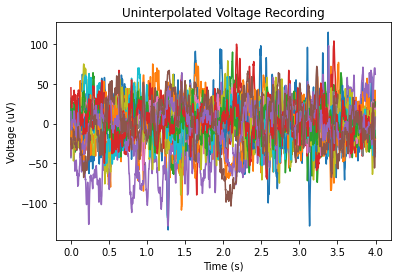

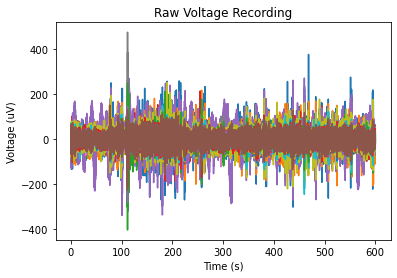

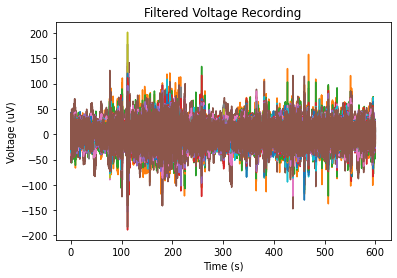

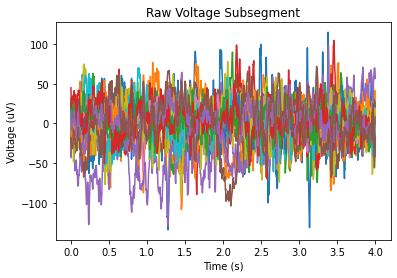

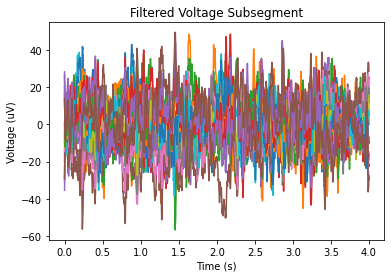

In [156]:
band_centers = [2, 6, 10, 20, 40]
basepath = os.path.dirname(os.path.realpath("__file__"))
parentpath = os.path.split(basepath)[0]
test_filepath = "seizure-prediction/Dog_1/Dog_1/Dog_1_interictal_segment_0001.mat"
path = os.path.join(parentpath, test_filepath)
varname = 'interictal_segment_1'
interictal_1 = Segment(path, varname, band_centers)


fig, ax = interictal_1.plot_uninterp(end_idx=int(interictal_1.raw_fs*4))
ax.set_title("Uninterpolated Voltage Recording")
fig, ax = interictal_1.plot_raw()
ax.set_title("Raw Voltage Recording")
fig, ax = interictal_1.plot_filt()
ax.set_title("Filtered Voltage Recording")
fig, ax = interictal_1.plot_raw(end_idx=interictal_1.fs*4)
ax.set_title("Raw Voltage Subsegment")
fig, ax = interictal_1.plot_filt(end_idx=interictal_1.fs*4)
_ = ax.set_title("Filtered Voltage Subsegment")

Visualize time-frequency representation

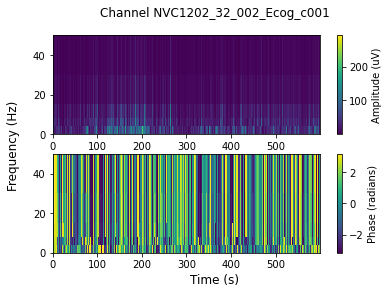

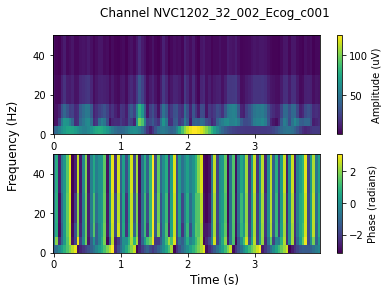

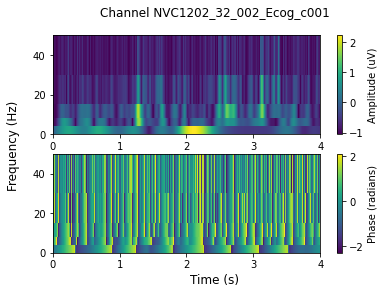

In [157]:
sample_channel = [interictal_1.channels[0]]
figs, axs = interictal_1.plot_tfr(sample_channel)
figs, axs = interictal_1.plot_tfr(sample_channel, end_idx=interictal_1.fs*4)
figs, axs = interictal_1.plot_feat(sample_channel)

In [158]:
del interictal_1 #remove sample segment from memory 

In [165]:
class EEGPreProcessor:
    """
    Class for pre-processing EEG data and extracting time-frequency representations
    """
    def __init__(self, root, saveroot, band_centers, filt_ord=1, low_cut=0.5, high_cut=50, down_freq=250, t_split=4):
        self.root = root #directory that contains raw data
        self.saveroot = saveroot #directory to save the preprocessed data
        self.seg_params = {} #segment preprocessing parameters
        self.band_centers = band_centers #frequencies for Morlet Wavelet Convolution
        self.seg_params['filt_ord'] = filt_ord #filtering order
        self.seg_params['low_cut'] = low_cut #low cutoff freq for bandpass
        self.seg_params['high_cut'] = high_cut #high cutoff freq for bandpass
        self.seg_params['down_freq'] = down_freq #downsampled frequency
        self.seg_params['t_split'] = t_split #subsegment length (s)
    
    def listsubfolders(self, root):
        """
        Helper function to list the subfolders in a directory
        """
        contents = os.listdir(root)
        subfolders = []
        for item in os.listdir(root):
            item_path = os.path.join(root, item)
            if not(os.path.isfile(item_path)):
                subfolders.append(item)
        return subfolders
    
    def __call__(self, pat_names, num_segs):
        if not(os.path.exists(self.saveroot)):
            os.mkdir(self.saveroot)
        for folder in self.listsubfolders(self.root):
            if not(folder in pat_names):
                continue
            print(folder)
            datapath = os.path.join(os.path.join(root, folder), folder)
            save_pat_path = os.path.join(saveroot, folder)
            if not(os.path.exists(save_pat_path)):
                os.mkdir(save_pat_path)
            matfiles = [file for file in os.listdir(datapath) if not("test" in file or
                                                                     ".DS_Store" in file or
                                                                     int(file[-8:-4]) > num_segs)]
            interictal_seg, preictal_seg = None, None
            for matfile in tqdm(matfiles):
                seg_path = os.path.join(datapath, matfile)
                seg_num = int(matfile[-8:-4])
                if "interictal" in matfile:
                    seg_name = "interictal_segment_"+str(seg_num)
                    seg = Segment(seg_path, seg_name, self.band_centers, **self.seg_params)
                    y = np.array(0)
                else: #preictal
                    seg_name = "preictal_segment_"+str(seg_num)
                    seg = Segment(seg_path, seg_name, self.band_centers, **self.seg_params)
                    y = np.array(1)
                save_seg_path = os.path.join(save_pat_path, seg_name)
                if not(os.path.exists(save_seg_path)):
                    os.mkdir(save_seg_path)
                for i, subseg in enumerate(seg.subsegments):
                    filepath = os.path.join(save_seg_path, str(i))
                    np.savez(filepath, X=subseg, y=y)

In [166]:
root = os.path.join(parentpath, "seizure-prediction")
saveroot = "PreProcData"
my_proc = EEGPreProcessor(root, saveroot, band_centers)

In [167]:
subs = ["Patient_1", "Patient_2", "Dog_1"]
num_segs = [18, 18, 24]
for sub, num_seg in zip(subs, num_segs):
    my_proc(sub, num_seg)

Patient_1


  0%|          | 0/36 [00:00<?, ?it/s]

Patient_2


  0%|          | 0/36 [00:00<?, ?it/s]

Dog_1


  0%|          | 0/48 [00:00<?, ?it/s]

## CNN

In [168]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.integrate import trapz as trapz

In [169]:
batch_size = 50 // 2

Set up Dataset and Dataloader

In [170]:
class SeizureData(Dataset):
    """Seizure Prediction Dataset"""
    
    def __init__(self, root, pat_name, seg_names, n_subseg):
        self.root = root
        self.pat_name = pat_name
        self.dir_path = os.path.join(root, pat_name)
        self.seg_names = seg_names
        self.n_seg = len(seg_names)
        self.n_subseg = n_subseg
    
    def __len__(self):
        return self.n_seg*self.n_subseg
    
    def __getitem__(self, idx):
        seg_idx = idx // self.n_subseg
        subseg_idx = idx % self.n_subseg
        seg_path = os.path.join(self.dir_path, self.seg_names[seg_idx])
        subseg_path = os.path.join(seg_path, str(subseg_idx)+".npz")
        subseg = np.load(subseg_path)
        X = torch.tensor(subseg['X']).float()
        y = torch.tensor(subseg['y']).float()
        return X, y

inter_segs = [seg_name for seg_name in os.listdir("PreProcData/Patient_1") if "interictal" in seg_name]
pre_segs = [seg_name for seg_name in os.listdir("PreProcData/Patient_1") if "preictal" in seg_name]
train_segs = inter_segs[:9]+pre_segs[:9]
test_segs = inter_segs[9:18]+pre_segs[9:]
n_subseg = 150
train_dataset = SeizureData("PreProcData", "Patient_1", train_segs, n_subseg)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = SeizureData("PreProcData", "Patient_1", test_segs, n_subseg)
test_dataloader = DataLoader(test_dataset, batch_size=n_subseg, shuffle=False)

Define Model Class

In [181]:
class PredIctal(nn.Module):
    """CNN for Predicting seizure from 4s subsegments"""
    
    def __init__(
                self,
                init_w=1000,
                init_h=5,
                num_channels=30,
                width=10,
                latent_size=20,
                filter_size=5,
                pool_filter_size=(1, 10),
                pad=0,
                stride=1,
                pool_stride=2):
        #inheriting nn.Module initialization
        super(PredIctal, self).__init__()
        
        #architecture variables
        self.init_w = init_w
        self.init_h = init_h
        self.num_channels = num_channels
        self.width = width
        self.latent_size = latent_size
        self.filter_size = filter_size
        self.pool_filter_size = pool_filter_size
        self.pad = pad
        self.stride = stride
        self.pool_stride = pool_stride
        
        #output sizes
        output1_w = (init_w - filter_size + 2*pad) // stride + 1
        output1_h = (init_h - filter_size + 2*pad) // stride + 1
        output2_w = (output1_w - pool_filter_size[1]) // pool_stride + 1
        output2_h = (output1_h - pool_filter_size[0]) // pool_stride + 1
        self.linear_size = output2_w * output2_h * self.width
        
        #architecture
        self.architecture = nn.Sequential(
            nn.Conv2d(self.num_channels, self.width, self.filter_size, self.stride, self.pad),
            nn.ReLU(),
            nn.MaxPool2d(self.pool_filter_size, self.pool_stride),
            nn.Flatten(),
            nn.Linear(self.linear_size, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.architecture(x).squeeze(1)

PredIctal()

PredIctal(
  (architecture): Sequential(
    (0): Conv2d(30, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 10), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=4940, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

Training Hyperparameters

Note: $\lambda_{norm}$ is a L2 Norm Regularization parameter from [here](https://towardsdatascience.com/weight-decay-and-its-peculiar-effects-66e0aee3e7b8) 

In [182]:
learning_rate = 0.01 / 2
num_epochs = 10
epoch_nums = [epoch for epoch in range(num_epochs)]
lambda_norm = 0.05 * 200
weight_decay = lambda_norm*np.sqrt(batch_size/(num_epochs*len(train_dataset)))

Define weight initializer, training and eval loops

In [183]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
    return
def train_loop(dataloader, model, loss_fn, optimizer, print_batch=False):
    prog_bar =  tqdm(dataloader, leave=False)
    for (x, y) in prog_bar:
        #Forward Pass
        pred = model(x)
        loss = loss_fn(pred, y)
        
        #Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    prog_bar.close()
    return

def eval_loop(dataloader, model, loss_fn, thresh=0.5, seg=False):
    eval_loss, ys, preds, true_preds = 0, [], [], []
    with torch.no_grad():
        prog_bar = tqdm(dataloader, leave=False)
        for x, y in prog_bar:
            pred = model(x)
            if seg:
                seg_pred = torch.mean(pred)
                true_preds.append(seg_pred)
                seg_y = y[0]
                eval_loss += loss_fn(seg_pred, seg_y).item()
                ys.append(seg_y.item())
                if seg_pred.item() >= thresh:
                    preds.append(1)
                else:
                    preds.append(0)
            else:
                eval_loss += loss_fn(pred, y).item()
                for yi, predi in zip(y, pred):
                    ys.append(yi.item())
                    true_preds.append(predi.item())
                    if predi.item() >= thresh:
                        preds.append(1)
                    else:
                        preds.append(0)
        prog_bar.close()
    avg_loss = eval_loss / len(dataloader)
    
    ys = np.array(ys)
    preds = np.array(preds)
    acc = np.sum(ys==preds) / len(ys)
    prec, recall, f1, _ = prf(ys, preds)
    stats = avg_loss, acc, prec, recall, f1
    predsNlabels = ys, preds, true_preds
    return stats, predsNlabels

def roc_eval_loop(y, true_preds, thresholds):
    fprs, tprs = [], []
    for thresh in thresholds:
        preds = true_preds >= thresh
        true_pos = np.sum(np.logical_and(y==preds, preds==1))
        false_pos = np.sum(np.logical_and(y!=preds, preds==1))
        true_neg = np.sum(np.logical_and(y==preds, preds==0))
        false_neg = np.sum(np.logical_and(y!=preds, preds==0))
        tpr = true_pos / (false_neg + true_pos) #true positive rate
        fpr = false_pos / (false_pos + true_neg) #false positive rate
        tprs.append(tpr)
        fprs.append(fpr)
    fprs, tprs = np.flip(fprs), np.flip(tprs)
    auc = trapz(tprs, fprs)

    return tprs, fprs, auc

def plot_init(dataloader, model, idx, ch_idx, freq_idx, num_channels=15):
    with torch.no_grad():
        for x, y in dataloader:
            t = np.linspace(0, 4, x.shape[-1])
            x_amps = x[:, num_channels:, :, :]
            x_phases = x[:, :num_channels, :, :]
            sample_amp = x_amps[idx, ch_idx, freq_idx, :]
            sample_phase = x_phases[idx, ch_idx, freq_idx, :]
            sample_y = y[idx]
            pred = model(x).numpy()
            sample_pred = pred[idx]

            fig, ax = plt.subplots(2, 1)
            ax[0].plot(t, sample_amp)
            ax[1].plot(t, sample_phase)
            ax[0].set_ylabel("Normalized Amplitude")
            ax[1].set_ylabel("Normalized Phase")
            ax[0].set_xticklabels([])
            fig.supxlabel("Time (s)")
            plt.show()
            
            print("y={}, pred={}".format(sample_y, sample_pred))
            break

Initialize

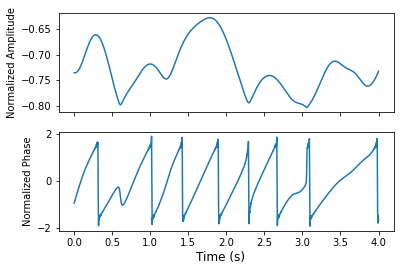

y=0.0, pred=0.672360360622406


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]


        Train:
            loss=0.899
            acc=0.47
                    interictal, preictal
          precision= 0.46,    0.48
          recall=    0.27,    0.67 
          f1=        0.34,    0.56

        Test:
            loss=0.935
            acc=0.43
                    interictal, preictal
          precision= 0.40,    0.44
          recall=    0.29,    0.56 
          f1=        0.34,    0.49

        Segment:
            loss=0.800
            acc=0.33
                    interictal, preictal
          precision= 0.00,    0.40
          recall=    0.00,    0.67
          f1=        0.00,    0.50


In [184]:
torch.random.manual_seed(1)
model = PredIctal().float()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
loss_fn = nn.BCELoss()
model.apply(weights_init)
idx, ch_idx, freq_idx = 0,0,0
plot_init(train_dataloader, model, idx, ch_idx, freq_idx)
init_train_stats, _ = eval_loop(train_dataloader, model, loss_fn)
init_test_stats, _ = eval_loop(test_dataloader, model, loss_fn)
init_seg_stats, _ = eval_loop(test_dataloader, model, loss_fn, seg=True)
def print_stats(train_stats, test_stats):
    print("""
        Train:
            loss={:.3f}
            acc={:.2f}
                    interictal, preictal
          precision= {:.2f},    {:.2f}
          recall=    {:.2f},    {:.2f} 
          f1=        {:.2f},    {:.2f}

        Test:
            loss={:.3f}
            acc={:.2f}
                    interictal, preictal
          precision= {:.2f},    {:.2f}
          recall=    {:.2f},    {:.2f} 
          f1=        {:.2f},    {:.2f}""".format(
        train_stats[0], train_stats[1], train_stats[2][0], train_stats[2][1],
        train_stats[3][0], train_stats[3][1], train_stats[4][0], train_stats[4][1],
        test_stats[0], test_stats[1], test_stats[2][0], test_stats[2][1],
        test_stats[3][0], test_stats[3][1], test_stats[4][0], test_stats[4][1]))
def print_segstats(seg_stats):
    print("""
        Segment:
            loss={:.3f}
            acc={:.2f}
                    interictal, preictal
          precision= {:.2f},    {:.2f}
          recall=    {:.2f},    {:.2f}
          f1=        {:.2f},    {:.2f}""".format(
        seg_stats[0], seg_stats[1], seg_stats[2][0], seg_stats[2][1],
        seg_stats[3][0], seg_stats[3][1], seg_stats[4][0], seg_stats[4][1]))
print_stats(init_train_stats, init_test_stats)
print_segstats(init_seg_stats)

Train

In [185]:
train_stats, test_stats = [init_train_stats], [init_test_stats]
for epoch in range(num_epochs):
    #Train
    model.train()
    train_loop(train_dataloader, model, loss_fn, optimizer)
    
    #Evaluate
    model.eval()
    train_stat, _ = eval_loop(train_dataloader, model, loss_fn)
    test_stat, _ = eval_loop(test_dataloader, model, loss_fn)

    if train_stat[0] > train_stats[-1][0]:
        scheduler.step()
        print("New Learnign Rate:", scheduler.get_last_lr()[0])
    
    print("Epoch:", epoch)
    print_stats(train_stat, test_stat)
    
    train_stats.append(train_stat)
    test_stats.append(test_stat)

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 0

        Train:
            loss=0.613
            acc=0.67
                    interictal, preictal
          precision= 0.82,    0.62
          recall=    0.44,    0.90 
          f1=        0.57,    0.73

        Test:
            loss=0.722
            acc=0.59
                    interictal, preictal
          precision= 0.82,    0.55
          recall=    0.23,    0.95 
          f1=        0.36,    0.70


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 1

        Train:
            loss=0.501
            acc=0.78
                    interictal, preictal
          precision= 0.84,    0.73
          recall=    0.68,    0.87 
          f1=        0.75,    0.80

        Test:
            loss=0.563
            acc=0.68
                    interictal, preictal
          precision= 0.84,    0.62
          recall=    0.44,    0.92 
          f1=        0.58,    0.74


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.0025
Epoch: 2

        Train:
            loss=0.610
            acc=0.63
                    interictal, preictal
          precision= 0.62,    0.64
          recall=    0.66,    0.60 
          f1=        0.64,    0.62

        Test:
            loss=0.549
            acc=0.64
                    interictal, preictal
          precision= 0.66,    0.62
          recall=    0.57,    0.71 
          f1=        0.61,    0.66


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 3

        Train:
            loss=0.501
            acc=0.81
                    interictal, preictal
          precision= 0.75,    0.90
          recall=    0.92,    0.70 
          f1=        0.83,    0.79

        Test:
            loss=0.469
            acc=0.76
                    interictal, preictal
          precision= 0.80,    0.72
          recall=    0.68,    0.83 
          f1=        0.74,    0.77


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 4

        Train:
            loss=0.491
            acc=0.79
                    interictal, preictal
          precision= 0.76,    0.82
          recall=    0.84,    0.74 
          f1=        0.80,    0.78

        Test:
            loss=0.501
            acc=0.71
                    interictal, preictal
          precision= 0.81,    0.66
          recall=    0.56,    0.86 
          f1=        0.66,    0.75


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 5

        Train:
            loss=0.451
            acc=0.83
                    interictal, preictal
          precision= 0.78,    0.91
          recall=    0.92,    0.74 
          f1=        0.85,    0.82

        Test:
            loss=0.489
            acc=0.76
                    interictal, preictal
          precision= 0.82,    0.72
          recall=    0.67,    0.85 
          f1=        0.73,    0.78


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 6

        Train:
            loss=0.428
            acc=0.82
                    interictal, preictal
          precision= 0.81,    0.84
          recall=    0.84,    0.80 
          f1=        0.83,    0.82

        Test:
            loss=0.590
            acc=0.74
                    interictal, preictal
          precision= 0.85,    0.68
          recall=    0.58,    0.90 
          f1=        0.69,    0.77


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.00125
Epoch: 7

        Train:
            loss=0.453
            acc=0.82
                    interictal, preictal
          precision= 0.81,    0.84
          recall=    0.85,    0.80 
          f1=        0.83,    0.82

        Test:
            loss=0.441
            acc=0.78
                    interictal, preictal
          precision= 0.84,    0.73
          recall=    0.69,    0.87 
          f1=        0.76,    0.80


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 8

        Train:
            loss=0.375
            acc=0.85
                    interictal, preictal
          precision= 0.87,    0.83
          recall=    0.82,    0.88 
          f1=        0.85,    0.86

        Test:
            loss=0.503
            acc=0.73
                    interictal, preictal
          precision= 0.96,    0.66
          recall=    0.49,    0.98 
          f1=        0.65,    0.79


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 9

        Train:
            loss=0.356
            acc=0.86
                    interictal, preictal
          precision= 0.85,    0.87
          recall=    0.88,    0.84 
          f1=        0.86,    0.86

        Test:
            loss=0.434
            acc=0.80
                    interictal, preictal
          precision= 0.93,    0.73
          recall=    0.65,    0.95 
          f1=        0.76,    0.83


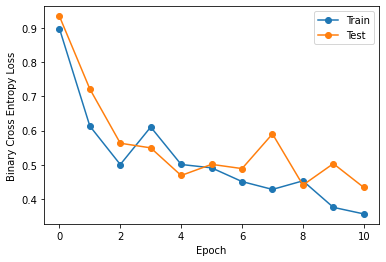

In [186]:
train_losses = np.array([train_stat[0] for train_stat in train_stats])
test_losses = np.array([test_stat[0] for test_stat in test_stats])

epoch_nums = np.arange(num_epochs+1)
plt.figure()
plt.hold = True
plt.plot(epoch_nums, train_losses, 'o-', label="Train")
plt.plot(epoch_nums, test_losses, 'o-', label="Test")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy Loss")
_ = plt.legend()

In [187]:
final_seg_stats, predsNlabels = eval_loop(test_dataloader, model, loss_fn, seg=True)
y, preds, true_preds = predsNlabels

  0%|          | 0/18 [00:00<?, ?it/s]

In [188]:
print_segstats(final_seg_stats)


        Segment:
            loss=0.387
            acc=0.83
                    interictal, preictal
          precision= 1.00,    0.75
          recall=    0.67,    1.00
          f1=        0.80,    0.86


ROC

ROCAUC= 1.0


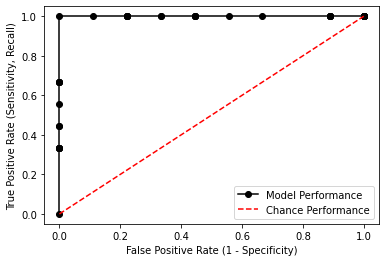

In [191]:
thresholds = np.linspace(0, 1, 41)
tprs, fprs, auc = roc_eval_loop(y, true_preds, thresholds)
print("ROCAUC=", auc)
plt.figure()
plt.hold = True
plt.plot(fprs, tprs, 'ko-')
plt.plot(fprs, fprs, 'r--')
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
_ = plt.legend(["Model Performance", "Chance Performance"])

## Patient 2!

Datasets and Dataloaders

In [192]:
batch_size = 50 // 2

In [193]:
inter_segs = [seg_name for seg_name in os.listdir("PreProcData/Patient_2") if "interictal" in seg_name]
pre_segs = [seg_name for seg_name in os.listdir("PreProcData/Patient_2") if "preictal" in seg_name]
train_segs = inter_segs[:9]+pre_segs[:9]
test_segs = inter_segs[9:18]+pre_segs[9:]
n_subseg = 150
train_dataset = SeizureData("PreProcData", "Patient_2", train_segs, n_subseg)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = SeizureData("PreProcData", "Patient_2", test_segs, n_subseg)
test_dataloader = DataLoader(test_dataset, batch_size=n_subseg, shuffle=False)

Note: $\lambda_{norm}$ is a L2 Norm Regularization parameter from [here](https://towardsdatascience.com/weight-decay-and-its-peculiar-effects-66e0aee3e7b8) 

In [194]:
learning_rate = 0.01 / 2
num_epochs = 20
epoch_nums = [epoch for epoch in range(num_epochs)]
lambda_norm = 0.05 * 100
weight_decay = lambda_norm*np.sqrt(batch_size/(num_epochs*len(train_dataset)))

Initialize

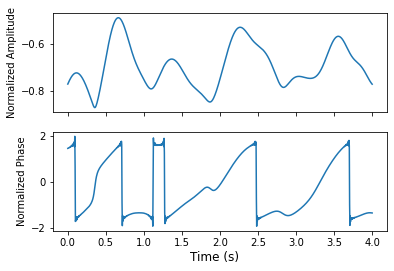

y=1.0, pred=0.9627819061279297


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]


        Train:
            loss=1.093
            acc=0.50
                    interictal, preictal
          precision= 0.52,    0.50
          recall=    0.07,    0.93 
          f1=        0.13,    0.65

        Test:
            loss=1.095
            acc=0.50
                    interictal, preictal
          precision= 0.50,    0.50
          recall=    0.08,    0.93 
          f1=        0.13,    0.65

        Segment:
            loss=0.902
            acc=0.50
                    interictal, preictal
          precision= 0.00,    0.50
          recall=    0.00,    1.00
          f1=        0.00,    0.67


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [195]:
torch.random.manual_seed(1)
model = PredIctal(num_channels=48).float()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
loss_fn = nn.BCELoss()
model.apply(weights_init)
idx, ch_idx, freq_idx = 0,0,0
plot_init(train_dataloader, model, idx, ch_idx, freq_idx, num_channels=24)
init_train_stats, _ = eval_loop(train_dataloader, model, loss_fn)
init_test_stats, _ = eval_loop(test_dataloader, model, loss_fn)
init_seg_stats, _ = eval_loop(test_dataloader, model, loss_fn, seg=True)
print_stats(init_train_stats, init_test_stats)
print_segstats(init_seg_stats)

Train

In [196]:
train_stats, test_stats, seg_stats = [init_train_stats], [init_test_stats], [init_seg_stats]
for epoch in range(num_epochs):
    #Train
    train_loop(train_dataloader, model, loss_fn, optimizer)
    
    #Evaluate
    train_stat, _ = eval_loop(train_dataloader, model, loss_fn)
    test_stat, _ = eval_loop(test_dataloader, model, loss_fn)
    #seg_stat = seg_eval_loop(test_dataloader, model)

    if train_stat[0] > train_stats[-1][0]:
        scheduler.step()
        print("New Learnign Rate:", scheduler.get_last_lr()[0])
    
    print("Epoch:", epoch)
    print_stats(train_stat, test_stat)
    
    train_stats.append(train_stat)
    test_stats.append(test_stat)
    #seg_stats.append(seg_stat)

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 0

        Train:
            loss=0.688
            acc=0.53
                    interictal, preictal
          precision= 0.55,    0.52
          recall=    0.30,    0.75 
          f1=        0.38,    0.61

        Test:
            loss=0.735
            acc=0.51
                    interictal, preictal
          precision= 0.52,    0.51
          recall=    0.22,    0.79 
          f1=        0.31,    0.62


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 1

        Train:
            loss=0.670
            acc=0.52
                    interictal, preictal
          precision= 0.52,    0.52
          recall=    0.51,    0.53 
          f1=        0.51,    0.52

        Test:
            loss=0.684
            acc=0.52
                    interictal, preictal
          precision= 0.52,    0.51
          recall=    0.40,    0.63 
          f1=        0.45,    0.57


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.0025
Epoch: 2

        Train:
            loss=0.673
            acc=0.59
                    interictal, preictal
          precision= 0.57,    0.62
          recall=    0.73,    0.44 
          f1=        0.64,    0.51

        Test:
            loss=0.677
            acc=0.55
                    interictal, preictal
          precision= 0.55,    0.57
          recall=    0.64,    0.46 
          f1=        0.59,    0.51


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 3

        Train:
            loss=0.662
            acc=0.56
                    interictal, preictal
          precision= 0.56,    0.56
          recall=    0.57,    0.55 
          f1=        0.56,    0.56

        Test:
            loss=0.666
            acc=0.55
                    interictal, preictal
          precision= 0.56,    0.54
          recall=    0.47,    0.63 
          f1=        0.51,    0.59


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.00125
Epoch: 4

        Train:
            loss=0.665
            acc=0.57
                    interictal, preictal
          precision= 0.58,    0.57
          recall=    0.53,    0.61 
          f1=        0.55,    0.59

        Test:
            loss=0.671
            acc=0.55
                    interictal, preictal
          precision= 0.56,    0.54
          recall=    0.44,    0.65 
          f1=        0.49,    0.59


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.000625
Epoch: 5

        Train:
            loss=0.701
            acc=0.52
                    interictal, preictal
          precision= 0.61,    0.51
          recall=    0.10,    0.93 
          f1=        0.17,    0.66

        Test:
            loss=0.753
            acc=0.51
                    interictal, preictal
          precision= 0.56,    0.51
          recall=    0.08,    0.93 
          f1=        0.15,    0.66


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 6

        Train:
            loss=0.592
            acc=0.70
                    interictal, preictal
          precision= 0.65,    0.78
          recall=    0.84,    0.55 
          f1=        0.73,    0.65

        Test:
            loss=0.622
            acc=0.66
                    interictal, preictal
          precision= 0.64,    0.68
          recall=    0.72,    0.60 
          f1=        0.68,    0.64


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 7

        Train:
            loss=0.523
            acc=0.75
                    interictal, preictal
          precision= 0.76,    0.75
          recall=    0.74,    0.76 
          f1=        0.75,    0.76

        Test:
            loss=0.599
            acc=0.69
                    interictal, preictal
          precision= 0.74,    0.66
          recall=    0.59,    0.79 
          f1=        0.65,    0.72


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 8

        Train:
            loss=0.496
            acc=0.77
                    interictal, preictal
          precision= 0.81,    0.73
          recall=    0.70,    0.84 
          f1=        0.75,    0.78

        Test:
            loss=0.628
            acc=0.68
                    interictal, preictal
          precision= 0.75,    0.64
          recall=    0.54,    0.82 
          f1=        0.63,    0.72


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 9

        Train:
            loss=0.477
            acc=0.78
                    interictal, preictal
          precision= 0.71,    0.90
          recall=    0.93,    0.62 
          f1=        0.81,    0.74

        Test:
            loss=0.591
            acc=0.71
                    interictal, preictal
          precision= 0.68,    0.75
          recall=    0.79,    0.62 
          f1=        0.73,    0.68


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 10

        Train:
            loss=0.436
            acc=0.80
                    interictal, preictal
          precision= 0.74,    0.89
          recall=    0.92,    0.68 
          f1=        0.82,    0.77

        Test:
            loss=0.610
            acc=0.72
                    interictal, preictal
          precision= 0.71,    0.73
          recall=    0.75,    0.69 
          f1=        0.73,    0.71


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 11

        Train:
            loss=0.425
            acc=0.82
                    interictal, preictal
          precision= 0.81,    0.83
          recall=    0.83,    0.81 
          f1=        0.82,    0.82

        Test:
            loss=0.624
            acc=0.69
                    interictal, preictal
          precision= 0.71,    0.68
          recall=    0.65,    0.74 
          f1=        0.68,    0.71


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 12

        Train:
            loss=0.412
            acc=0.82
                    interictal, preictal
          precision= 0.83,    0.82
          recall=    0.81,    0.83 
          f1=        0.82,    0.82

        Test:
            loss=0.640
            acc=0.69
                    interictal, preictal
          precision= 0.74,    0.66
          recall=    0.59,    0.80 
          f1=        0.66,    0.72


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 13

        Train:
            loss=0.406
            acc=0.83
                    interictal, preictal
          precision= 0.79,    0.87
          recall=    0.89,    0.77 
          f1=        0.84,    0.82

        Test:
            loss=0.619
            acc=0.71
                    interictal, preictal
          precision= 0.71,    0.71
          recall=    0.71,    0.72 
          f1=        0.71,    0.71


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 14

        Train:
            loss=0.353
            acc=0.85
                    interictal, preictal
          precision= 0.81,    0.91
          recall=    0.92,    0.79 
          f1=        0.86,    0.84

        Test:
            loss=0.654
            acc=0.72
                    interictal, preictal
          precision= 0.72,    0.73
          recall=    0.73,    0.72 
          f1=        0.73,    0.72


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.0003125
Epoch: 15

        Train:
            loss=0.436
            acc=0.79
                    interictal, preictal
          precision= 0.71,    0.96
          recall=    0.97,    0.61 
          f1=        0.82,    0.75

        Test:
            loss=0.672
            acc=0.72
                    interictal, preictal
          precision= 0.67,    0.80
          recall=    0.86,    0.58 
          f1=        0.75,    0.67


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 16

        Train:
            loss=0.327
            acc=0.87
                    interictal, preictal
          precision= 0.88,    0.85
          recall=    0.85,    0.88 
          f1=        0.86,    0.87

        Test:
            loss=0.701
            acc=0.70
                    interictal, preictal
          precision= 0.74,    0.67
          recall=    0.62,    0.78 
          f1=        0.67,    0.72


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.00015625
Epoch: 17

        Train:
            loss=0.353
            acc=0.85
                    interictal, preictal
          precision= 0.93,    0.79
          recall=    0.75,    0.94 
          f1=        0.83,    0.86

        Test:
            loss=0.748
            acc=0.67
                    interictal, preictal
          precision= 0.75,    0.63
          recall=    0.52,    0.83 
          f1=        0.61,    0.72


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 18

        Train:
            loss=0.343
            acc=0.84
                    interictal, preictal
          precision= 0.77,    0.95
          recall=    0.96,    0.72 
          f1=        0.86,    0.82

        Test:
            loss=0.690
            acc=0.73
                    interictal, preictal
          precision= 0.70,    0.78
          recall=    0.81,    0.66 
          f1=        0.75,    0.71


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 19

        Train:
            loss=0.337
            acc=0.84
                    interictal, preictal
          precision= 0.78,    0.95
          recall=    0.96,    0.73 
          f1=        0.86,    0.82

        Test:
            loss=0.707
            acc=0.73
                    interictal, preictal
          precision= 0.70,    0.78
          recall=    0.81,    0.64 
          f1=        0.75,    0.70


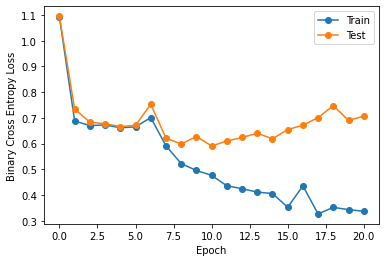

In [197]:
train_losses = np.array([train_stat[0] for train_stat in train_stats])
test_losses = np.array([test_stat[0] for test_stat in test_stats])

epoch_nums = np.arange(num_epochs+1)
plt.figure()
plt.hold = True
plt.plot(epoch_nums, train_losses, 'o-', label="Train")
plt.plot(epoch_nums, test_losses, 'o-', label="Test")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy Loss")
_ = plt.legend()

In [198]:
final_seg_stats, predsNlabels = eval_loop(test_dataloader, model, loss_fn, seg=True)
y, preds, true_preds = predsNlabels

  0%|          | 0/18 [00:00<?, ?it/s]

In [199]:
print_segstats(final_seg_stats)


        Segment:
            loss=0.464
            acc=0.78
                    interictal, preictal
          precision= 0.73,    0.86
          recall=    0.89,    0.67
          f1=        0.80,    0.75


ROC

ROCAUC= 0.8641975308641976


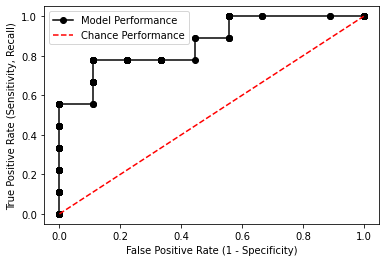

In [203]:
thresholds = np.linspace(0, 1, 201)
tprs, fprs, auc = roc_eval_loop(y, true_preds, thresholds)
print("ROCAUC=", auc)
plt.figure()
plt.hold = True
plt.plot(fprs, tprs, 'ko-')
plt.plot(fprs, fprs, 'r--')
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
_ = plt.legend(["Model Performance", "Chance Performance"])

Save model for future use

In [204]:
torch.save(model, "Patient2Model.pt")

## Dog 1 

Datasets and Dataloaders

In [205]:
batch_size = 50

In [206]:
inter_segs = [seg_name for seg_name in os.listdir("PreProcData/Dog_1") if "interictal" in seg_name]
pre_segs = [seg_name for seg_name in os.listdir("PreProcData/Dog_1") if "preictal" in seg_name]
train_segs = inter_segs[:12]+pre_segs[:12]
test_segs = inter_segs[12:24]+pre_segs[12:]
n_subseg = 150
train_dataset = SeizureData("PreProcData", "Dog_1", train_segs, n_subseg)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = SeizureData("PreProcData", "Dog_1", test_segs, n_subseg)
test_dataloader = DataLoader(test_dataset, batch_size=n_subseg, shuffle=False)

Note: $\lambda_{norm}$ is a L2 Norm Regularization parameter from [here](https://towardsdatascience.com/weight-decay-and-its-peculiar-effects-66e0aee3e7b8) 

In [210]:
learning_rate = 0.01 / 2
num_epochs = 10
epoch_nums = [epoch for epoch in range(num_epochs)]
lambda_norm = 0.05 * 100
weight_decay = lambda_norm*np.sqrt(batch_size/(num_epochs*len(train_dataset)))

Initialize

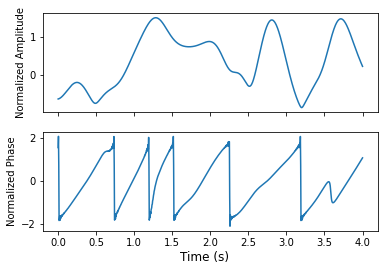

y=1.0, pred=0.613321840763092


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


        Train:
            loss=1.071
            acc=0.50
                    interictal, preictal
          precision= 0.50,    0.50
          recall=    0.14,    0.86 
          f1=        0.22,    0.63

        Test:
            loss=1.102
            acc=0.49
                    interictal, preictal
          precision= 0.45,    0.49
          recall=    0.12,    0.85 
          f1=        0.19,    0.62

        Segment:
            loss=0.875
            acc=0.50
                    interictal, preictal
          precision= 0.00,    0.50
          recall=    0.00,    1.00
          f1=        0.00,    0.67


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [211]:
torch.random.manual_seed(1)
model = PredIctal(num_channels=32).float()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
loss_fn = nn.BCELoss()
model.apply(weights_init)
idx, ch_idx, freq_idx = 0,0,0
plot_init(train_dataloader, model, idx, ch_idx, freq_idx, num_channels=24)
init_train_stats, _ = eval_loop(train_dataloader, model, loss_fn)
init_test_stats, _ = eval_loop(test_dataloader, model, loss_fn)
init_seg_stats, _ = eval_loop(test_dataloader, model, loss_fn, seg=True)
print_stats(init_train_stats, init_test_stats)
print_segstats(init_seg_stats)

Train

In [212]:
train_stats, test_stats, seg_stats = [init_train_stats], [init_test_stats], [init_seg_stats]
for epoch in range(num_epochs):
    #Train
    model.train()
    train_loop(train_dataloader, model, loss_fn, optimizer)
    
    #Evaluate
    model.eval()
    train_stat, _ = eval_loop(train_dataloader, model, loss_fn)
    test_stat, _ = eval_loop(test_dataloader, model, loss_fn)
    #seg_stat = seg_eval_loop(test_dataloader, model)

    if train_stat[0] > train_stats[-1][0]:
        scheduler.step()
        print("New Learnign Rate:", scheduler.get_last_lr()[0])
    
    print("Epoch:", epoch)
    print_stats(train_stat, test_stat)
    
    train_stats.append(train_stat)
    test_stats.append(test_stat)
    #seg_stats.append(seg_stat)

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 0

        Train:
            loss=0.680
            acc=0.57
                    interictal, preictal
          precision= 0.54,    0.69
          recall=    0.89,    0.26 
          f1=        0.67,    0.37

        Test:
            loss=0.691
            acc=0.53
                    interictal, preictal
          precision= 0.52,    0.60
          recall=    0.89,    0.17 
          f1=        0.65,    0.27


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 1

        Train:
            loss=0.662
            acc=0.61
                    interictal, preictal
          precision= 0.69,    0.58
          recall=    0.40,    0.82 
          f1=        0.51,    0.68

        Test:
            loss=0.678
            acc=0.59
                    interictal, preictal
          precision= 0.64,    0.57
          recall=    0.41,    0.77 
          f1=        0.50,    0.65


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

New Learnign Rate: 0.0025
Epoch: 2

        Train:
            loss=0.688
            acc=0.56
                    interictal, preictal
          precision= 0.62,    0.54
          recall=    0.30,    0.81 
          f1=        0.40,    0.65

        Test:
            loss=0.705
            acc=0.55
                    interictal, preictal
          precision= 0.60,    0.53
          recall=    0.27,    0.82 
          f1=        0.37,    0.64


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 3

        Train:
            loss=0.591
            acc=0.67
                    interictal, preictal
          precision= 0.62,    0.82
          recall=    0.90,    0.44 
          f1=        0.73,    0.57

        Test:
            loss=0.589
            acc=0.65
                    interictal, preictal
          precision= 0.60,    0.80
          recall=    0.90,    0.39 
          f1=        0.72,    0.52


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 4

        Train:
            loss=0.570
            acc=0.72
                    interictal, preictal
          precision= 0.76,    0.69
          recall=    0.64,    0.79 
          f1=        0.70,    0.74

        Test:
            loss=0.537
            acc=0.72
                    interictal, preictal
          precision= 0.75,    0.70
          recall=    0.67,    0.78 
          f1=        0.71,    0.74


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 5

        Train:
            loss=0.551
            acc=0.74
                    interictal, preictal
          precision= 0.78,    0.72
          recall=    0.68,    0.81 
          f1=        0.73,    0.76

        Test:
            loss=0.603
            acc=0.68
                    interictal, preictal
          precision= 0.70,    0.66
          recall=    0.63,    0.73 
          f1=        0.66,    0.69


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

New Learnign Rate: 0.00125
Epoch: 6

        Train:
            loss=0.582
            acc=0.69
                    interictal, preictal
          precision= 0.69,    0.70
          recall=    0.71,    0.67 
          f1=        0.70,    0.69

        Test:
            loss=0.591
            acc=0.65
                    interictal, preictal
          precision= 0.64,    0.66
          recall=    0.67,    0.62 
          f1=        0.66,    0.64


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 7

        Train:
            loss=0.511
            acc=0.75
                    interictal, preictal
          precision= 0.89,    0.68
          recall=    0.56,    0.93 
          f1=        0.69,    0.79

        Test:
            loss=0.575
            acc=0.72
                    interictal, preictal
          precision= 0.84,    0.67
          recall=    0.55,    0.90 
          f1=        0.67,    0.76


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 8

        Train:
            loss=0.500
            acc=0.77
                    interictal, preictal
          precision= 0.73,    0.82
          recall=    0.85,    0.69 
          f1=        0.78,    0.75

        Test:
            loss=0.584
            acc=0.68
                    interictal, preictal
          precision= 0.64,    0.74
          recall=    0.80,    0.56 
          f1=        0.71,    0.64


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 9

        Train:
            loss=0.471
            acc=0.79
                    interictal, preictal
          precision= 0.75,    0.84
          recall=    0.87,    0.71 
          f1=        0.80,    0.77

        Test:
            loss=0.567
            acc=0.68
                    interictal, preictal
          precision= 0.64,    0.75
          recall=    0.81,    0.55 
          f1=        0.72,    0.63


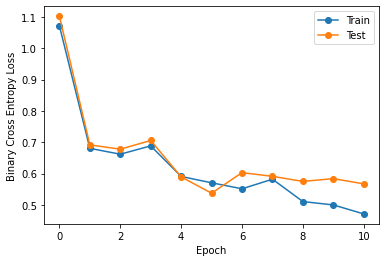

In [213]:
train_losses = np.array([train_stat[0] for train_stat in train_stats])
test_losses = np.array([test_stat[0] for test_stat in test_stats])

epoch_nums = np.arange(num_epochs+1)
plt.figure()
plt.hold = True
plt.plot(epoch_nums, train_losses, 'o-', label="Train")
plt.plot(epoch_nums, test_losses, 'o-', label="Test")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy Loss")
_ = plt.legend()

In [214]:
final_seg_stats, predsNlabels = eval_loop(test_dataloader, model, loss_fn, seg=True)
y, preds, true_preds = predsNlabels

  0%|          | 0/24 [00:00<?, ?it/s]

In [215]:
print_segstats(final_seg_stats)


        Segment:
            loss=0.493
            acc=0.79
                    interictal, preictal
          precision= 0.71,    1.00
          recall=    1.00,    0.58
          f1=        0.83,    0.74


ROC

ROCAUC= 0.9895833333333333


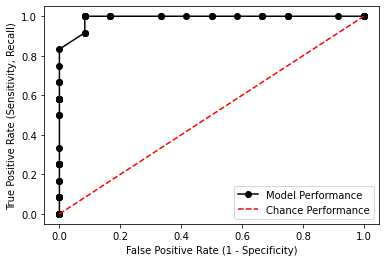

In [221]:
thresholds = np.linspace(0, 1, 101)
tprs, fprs, auc = roc_eval_loop(y, true_preds, thresholds)
print("ROCAUC=", auc)
plt.figure()
plt.hold = True
plt.plot(fprs, tprs, 'ko-')
plt.plot(fprs, fprs, 'r--')
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
_ = plt.legend(["Model Performance", "Chance Performance"])

Save model for future use

In [217]:
torch.save(model, "Dog1Model.pt")